In [1]:
# Regularized Subset Selection Project
# Ameya Shere and Neil Menghani

# Goal: To run a simulation of feature selection using LASSO and Elastic-Net regularization in order 
#       to verify the correct subset selection results (Thms. 3.5, 3.7, pgs. 1169-1170) from the paper:
#           Florentina Bunea. 2008. Honest variable selection in linear and logistic regression models
#             via l1 and l1 + l2 penalization. Electronic Journal of Statistics, 2:1153–1194

# Definition for B is given in the propositions above, def for L and centered/normalized assumption
# given in Notation section, pg. 1156

In [2]:
import numpy as np
import math, random
from numpy import linalg, matlib
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import matplotlib.pyplot as plt

In [3]:
# function to generate new design matrix
# params:
#   n: number of samples (rows of matrix)
#   M: number of features (columns of matrix)
#   B: upper bound on beta
#   L: upper bound on Xij's
#   k_star: number of true feature columns. Note: I_star will be the first k_star variables
#.  epsilon: variance of random noise introduced to y
# returns:
#   X, y, Beta
def generate_data(n, M, B, k_star, epsilon, model='linear',noise_prop=0.0):
    # generate random (normally distributed) data
    # for uncorrelated true feature columns
    X_signal = np.random.normal(0, 1, (n, k_star)) 

    # calculate the other non-true-feature columns
    # as a linear function of the true feature columns
    for i in range(M-k_star):
        combination = np.random.uniform(-1, 1, (k_star, 1))
        other_col = X_signal[:, :k_star] @ combination
        X_signal = np.concatenate([X_signal, other_col], axis=1)

    # decrease the correlation of the non-true-feature columns with
    # the feature columns by an amount proportional to noise_prop
    for j in range(k_star, M):
        try:
            noise_idxs = np.array(random.sample(range(0,n-1),int(noise_prop*n)))
        except ValueError:
            print(noise_prop*n)
            print(n)
        for i in noise_idxs:
            X_signal[i,j] = np.random.normal(0, 1)

    # center and normalize the data (assumption from paper, pg. 1156, Notation section)
    scaler.fit(X_signal)
    X = scaler.transform(X_signal)
    
    # use L to bound data
    L = abs(max(X.min(), X.max(), key=abs))
        
    # generate coefficents bounded by B
    Beta = np.random.uniform(-B, B, (k_star, 1))
    Beta = np.concatenate([Beta, np.zeros((M-k_star, 1))])

    # calculate y
    if model == 'linear':
        y = X @ Beta + np.random.normal(0, epsilon, (n, 1))
    elif model == 'logistic':
        y = 1/(1+np.e**-(X @ Beta + np.random.normal(0, epsilon, (n, 1))))
        threshold = 0.5
        y = (y>=0.5)*np.ones(y.shape) + (y<0.5)*np.zeros(y.shape)
    else:
        print("Error")
        return None

    return X, y, Beta, L

# function to get selected subset based on coefficents
def get_subset(coefs, tolerance):
    I_hat = set()
    for i, coef in enumerate(coefs):
        if abs(coef) > tolerance:
            I_hat.add(i)
            
    return I_hat

# function that outputs number of correctly selected features
def validate_subset(I_star, I_hat):
    return len(I_hat.intersection(I_star)), len(I_hat.difference(I_star))

# function to run one iteration of simulation
# returns number of true features selected
def simul_one(n, M, B, k_star, delta, model, noise_prop=0.0):
    epsilon = 1/math.sqrt(n)
    
    if model == 'linear_lasso':
        X, y, Beta, L = generate_data(n, M, B, k_star, epsilon, 'linear',noise_prop)
        r = 8*L*np.log((4*k_star*M)/delta)/n
        regr = lm.Lasso(alpha=2*r, tol=10-3)
    if model == 'linear_elastic_net':
        X, y, Beta, L = generate_data(n, M, B, k_star, epsilon, 'linear',noise_prop)
        r = 8*L*np.log((4*k_star*M)/delta)/n
        c = r/(2*B)
        # amount of l1 contribution for use in ElasticNet function
        l1_ratio = 2*r / (2*r + c)
        regr = lm.ElasticNet(alpha=2*r, l1_ratio=l1_ratio, tol=10-3)
    if model == 'logistic_lasso':
        X, y, Beta, L = generate_data(n, M, B, k_star, epsilon, 'logistic',noise_prop)
        r = (6+4*math.sqrt(2))*L*math.sqrt(2*math.log(2)*M/n)+2*L*math.sqrt(2*math.log((2*M)/delta)/n)+1/(4*n)
        regr = lm.LogisticRegression(penalty='l1',solver='liblinear',C=1/(2*r),tol=10-3)
    if model == 'logistic_elastic_net':
        X, y, Beta, L = generate_data(n, M, B, k_star, epsilon, 'logistic',noise_prop)
        r = (6+4*math.sqrt(2))*L*math.sqrt(2*math.log(2)*M/n)+2*L*math.sqrt(2*math.log((2*M)/delta)/n)+1/(4*n)
        c = r/(2*B)
        # amount of l1 contribution for use in ElasticNet function
        l1_ratio = 2*r / (2*r + c)
        regr = lm.LogisticRegression(penalty='elasticnet',solver='saga',C=1/(2*r),l1_ratio=l1_ratio, tol=10-3)

    if 'logistic' in model:
        regr.fit(X, np.ravel(y))
        regr.coef_ = regr.coef_.T
    else:
        regr.fit(X, y)
    
    I_star = set(range(0,k_star-1,1))
    I_hat = get_subset(regr.coef_,1)
    num_true, num_false = validate_subset(I_star, I_hat)
    l1_error = linalg.norm(regr.coef_-Beta.T, ord=1)
    l2_error = linalg.norm(regr.coef_-Beta.T, ord=2)
    return num_true, num_false, l1_error, l2_error

# given results of simulation, plot the number of true and false features selected and the L1 and L2 errors
def save_plots(true_features_selected,false_features_selected,l1_errors,l2_errors,model,sample_sizes,noise_props,n=-1,noise_prop=-1):
    model = ' '.join(model.split('_')).title()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    if n != -1:
        ax[0,0].plot(noise_props, true_features_selected,'bo')
        ax[0,0].set_title(model + ' true features selected\nn = ' + str(n))
        ax[0,0].set_xlabel('Proportion of non-feature columns changed to noisy data (noise_prop)')
    if noise_prop != -1:
        ax[0,0].plot(sample_sizes, true_features_selected,'bo')
        ax[0,0].set_title(model + ' true features selected\nnoise_prop = ' + str(noise_prop))
        ax[0,0].set_xlabel('Sample size (n)')
    ax[0,0].set_ylabel('Number of true features selected')

    if n != -1:
        ax[0,1].plot(noise_props, false_features_selected,'go')
        ax[0,1].set_title(model + ' features wrongly selected\nn = ' + str(n))
        ax[0,1].set_xlabel('Proportion of non-feature columns changed to noisy data (noise_prop)')
    if noise_prop != -1:
        ax[0,1].plot(sample_sizes, false_features_selected,'go')
        ax[0,1].set_title(model + ' features wrongly selected\nnoise_prop = ' + str(noise_prop))
        ax[0,1].set_xlabel('Sample size (n)')
    ax[0,1].set_ylabel('Number of features wrongly selected')

    if n != -1:
        ax[1,0].plot(noise_props, l1_errors,'co')
        ax[1,0].set_title(model + ' L1 error of betas\nn = ' + str(n))
        ax[1,0].set_xlabel('Proportion of non-feature columns changed to noisy data (noise_prop)')
    if noise_prop != -1:
        ax[1,0].plot(sample_sizes, l1_errors,'co')
        ax[1,0].set_title(model + ' L1 error of betas\nnoise_prop = ' + str(noise_prop))
        ax[1,0].set_xlabel('Sample size (n)')
    ax[1,0].set_ylabel('L1 error of calculated betas and true betas')

    if n != -1:
        ax[1,1].plot(noise_props, l2_errors,'mo')
        ax[1,1].set_title(model + ' L2 error of betas\nn = ' + str(n))
        ax[1,1].set_xlabel('Proportion of non-feature columns changed to noisy data (noise_prop)')
    if noise_prop != -1:
        ax[1,1].plot(sample_sizes, l2_errors,'mo')
        ax[1,1].set_title(model + ' L2 error of betas\nnoise_prop = ' + str(noise_prop))
        ax[1,1].set_xlabel('Sample size (n)')
    ax[1,1].set_ylabel('L2 error of calculated betas and true betas')
    if n!=-1:
        plt.savefig(model + '_noise_prop.jpg')
    if noise_prop!=-1:
        plt.savefig(model+"_sample_size.jpg")
    plt.show()
    plt.clf()

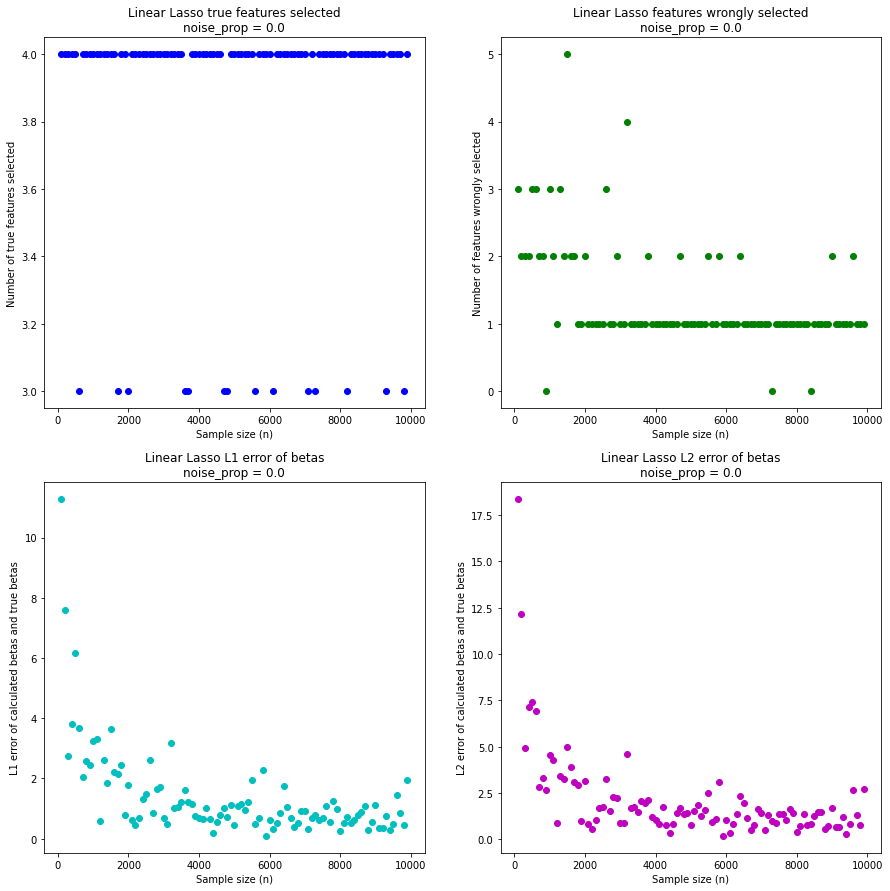

<Figure size 432x288 with 0 Axes>

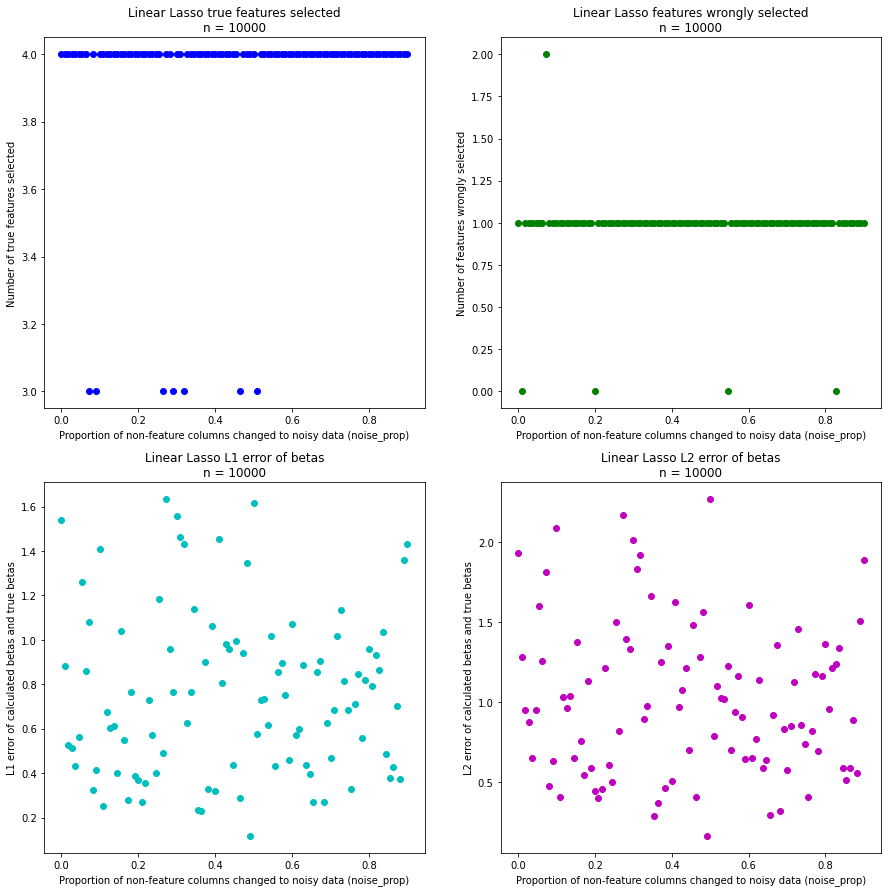

<Figure size 432x288 with 0 Axes>

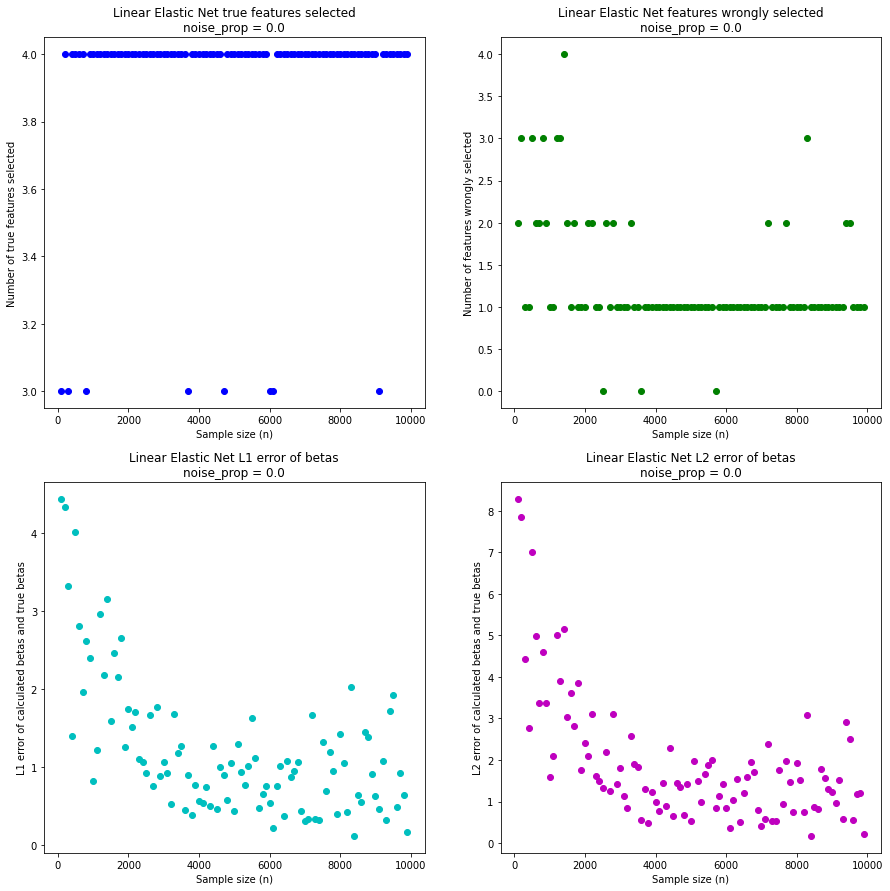

<Figure size 432x288 with 0 Axes>

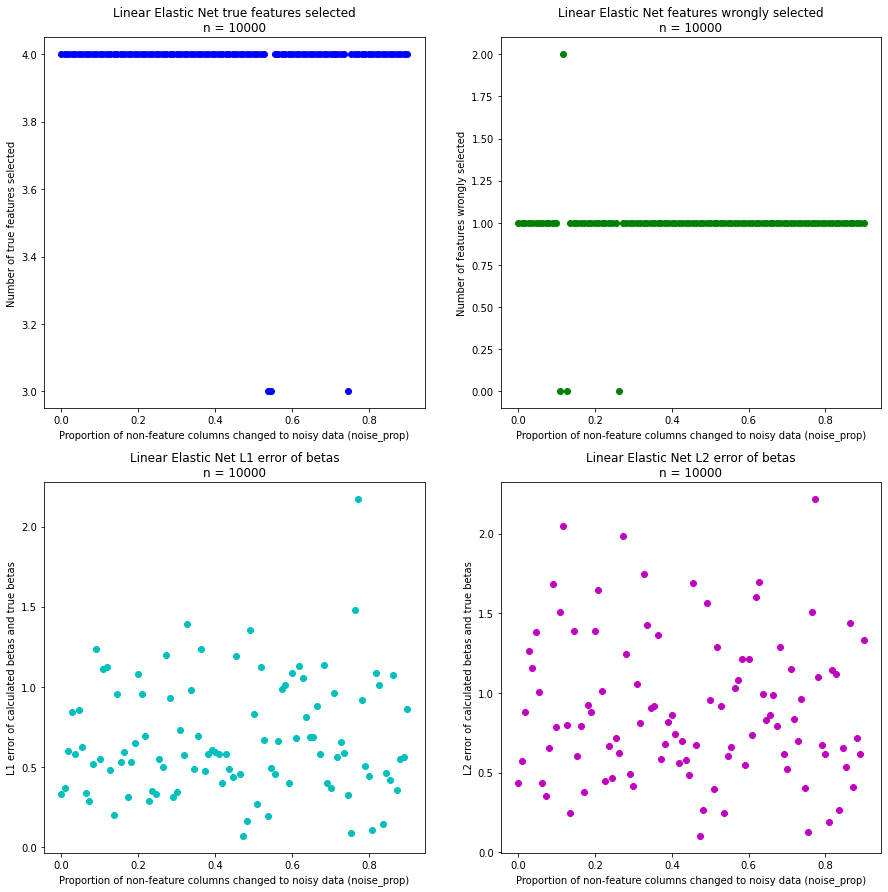

<Figure size 432x288 with 0 Axes>

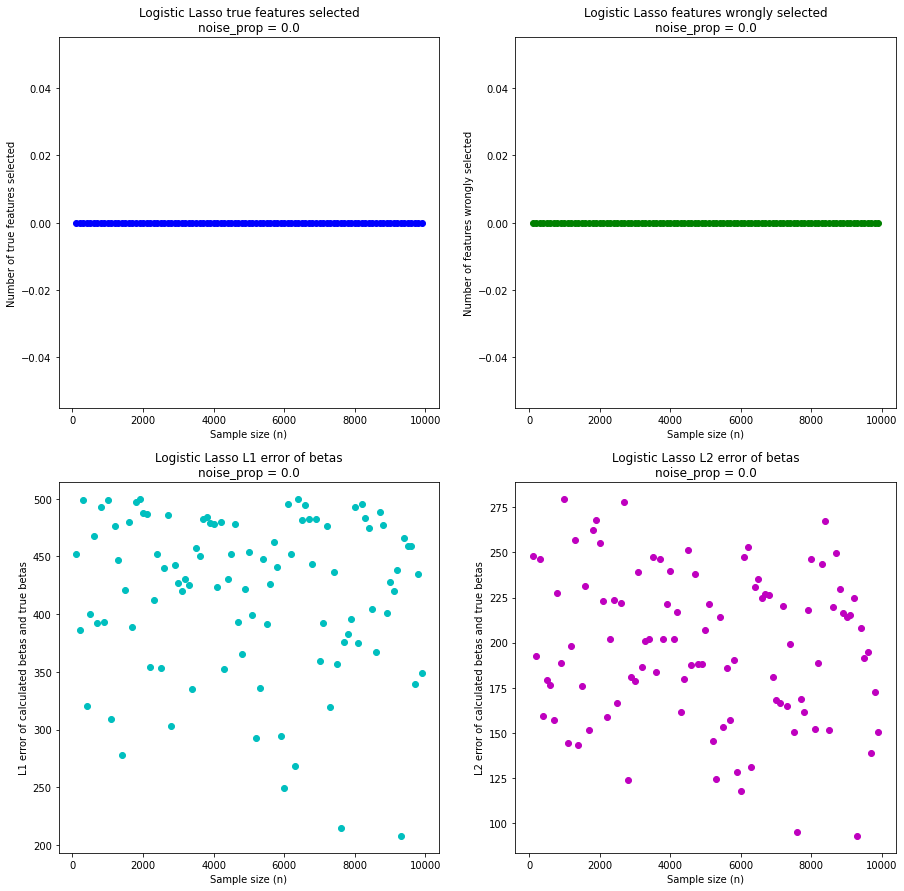

<Figure size 432x288 with 0 Axes>

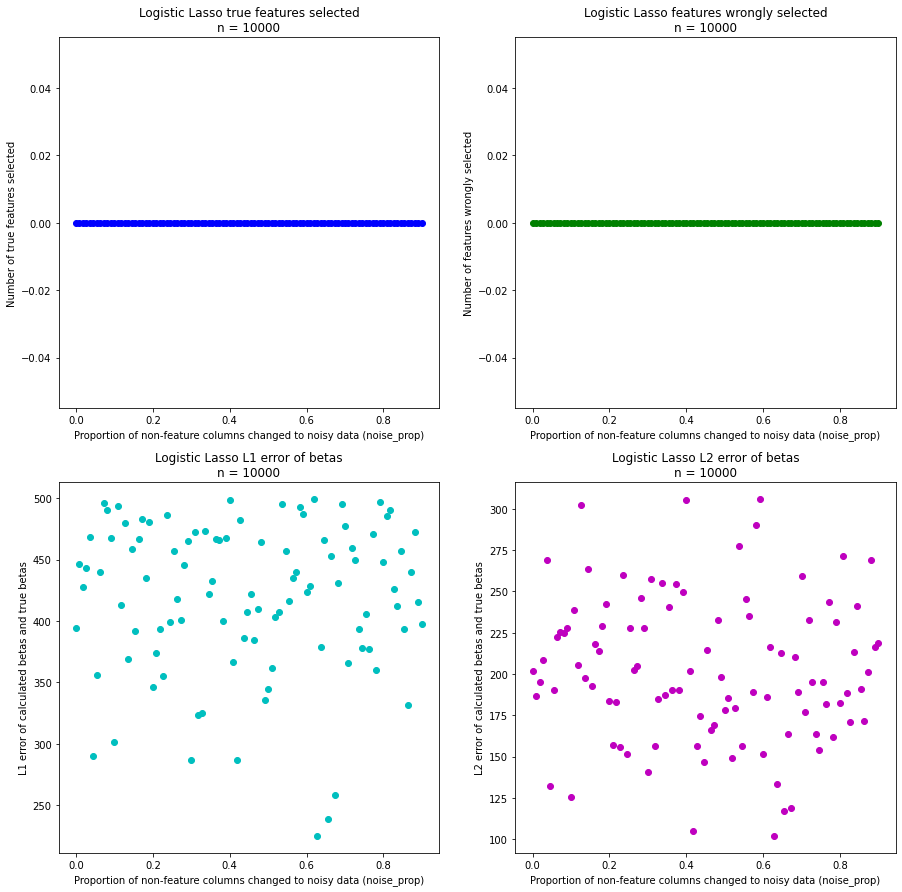

<Figure size 432x288 with 0 Axes>

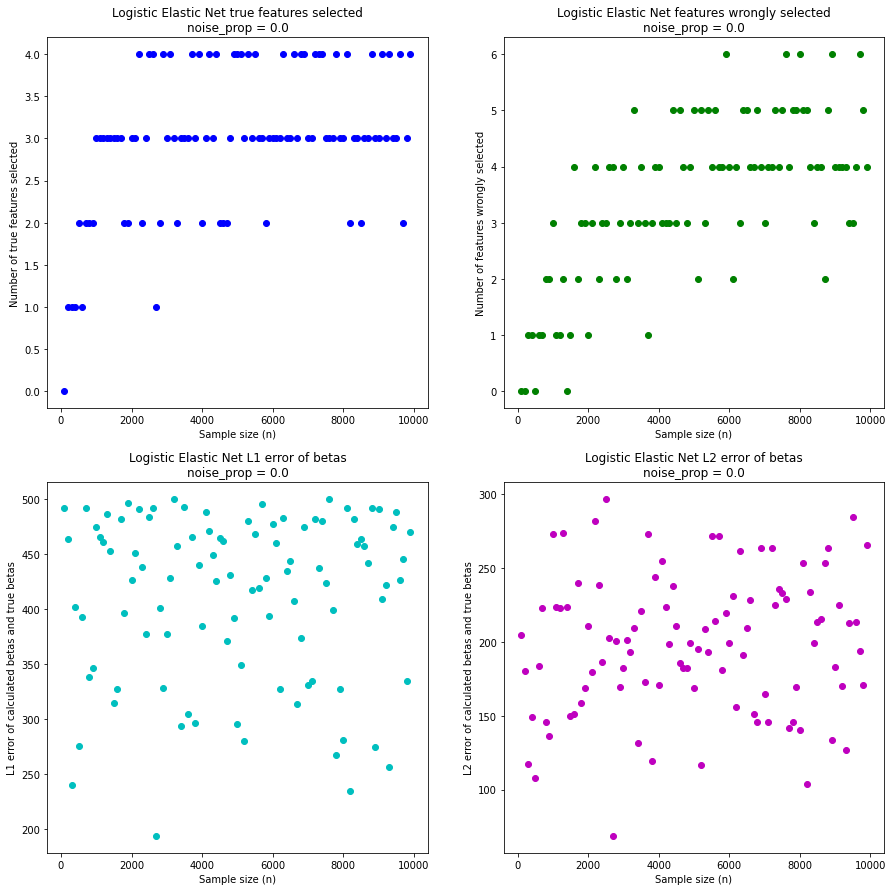

<Figure size 432x288 with 0 Axes>

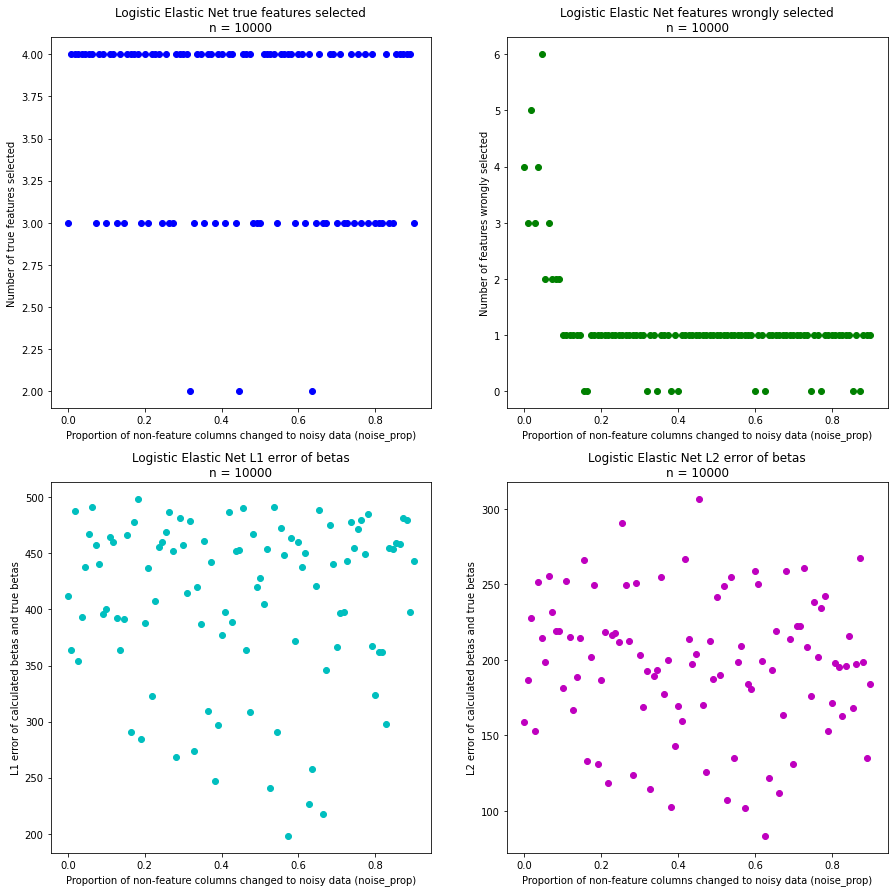

<Figure size 432x288 with 0 Axes>

In [4]:
# set random seed
np.random.seed(2021)

# number of features
M = 10
# number of true feature columns
k_star = 5
# upper bound on coefficient size in absolute value
B = 50
# 1 - confidence level
delta = 0.05

models = ['linear_lasso','linear_elastic_net','logistic_lasso','logistic_elastic_net']
sample_sizes = range(100, 10000, 100)
noise_props = np.linspace(0,0.9,100)

for model in models:
    # plot the sample size against subset selection and beta error
    # for noise_prop = 0
    true_features_selected = []
    false_features_selected = []
    l1_errors = []
    l2_errors = []
    noise_prop = 0.0

    for n in sample_sizes:
        num_true, num_false, l1_error, l2_error = simul_one(n, M, B, k_star, delta, model,noise_prop)
        true_features_selected.append(num_true)
        false_features_selected.append(num_false)
        l1_errors.append(l1_error)
        l2_errors.append(l2_error)

    save_plots(true_features_selected,false_features_selected,l1_errors,l2_errors,model,sample_sizes,noise_props,noise_prop=noise_prop)

    # plot the noise_props against subset selection and beta error
    # for n = 10,000
    true_features_selected = []
    false_features_selected = []
    l1_errors = []
    l2_errors = []
    n = 10000

    for noise_prop in noise_props:
        num_true, num_false, l1_error, l2_error = simul_one(n, M, B, k_star, delta, model,noise_prop=noise_prop)
        true_features_selected.append(num_true)
        false_features_selected.append(num_false)
        l1_errors.append(l1_error)
        l2_errors.append(l2_error)

    save_plots(true_features_selected,false_features_selected,l1_errors,l2_errors,model,sample_sizes,noise_props,n=n)